# Chapter 06: Caveats of Hierarchical Modeling

In the previous chapter we saw how partial pooling allows related series to share seasonal information through a hierarchical structure, producing coherent predictions even in data gaps. In this chapter, we explore two important **caveats** of hierarchical modeling as implemented in vangja (following the [timeseers](https://github.com/MBrouns/timeseers) approach):

1. **Shrinkage strength is a hyperparameter** — The `shrinkage_strength` parameter controls how strongly individual series are pulled toward the shared mean. Different values produce different results, and there is no universal default. This parameter must be tuned for each problem.

2. **Opposite seasonality and the UniformConstant trick** — The timeseers library proposes using `UniformConstant(-1, 1)` as a multiplicative factor on seasonality to handle series with opposite seasonal patterns (e.g., summer vs winter products). We investigate whether this is necessary or whether partial pooling on the Fourier coefficients already handles opposite seasonality implicitly.

## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality, UniformConstant
from vangja.datasets import generate_hierarchical_products
from vangja.utils import metrics, remove_random_gaps

print("Imports successful!")

Imports successful!


## Data Generation

We use the same data generation process as in Chapter 05: synthetic products with summer/winter seasonality and random gaps.

In [3]:
# Same data generation as Chapter 05
df_full, product_params = generate_hierarchical_products(seed=42, include_all_year=True)

np.random.seed(42)
df_parts = []
for name, params in product_params.items():
    series_data = df_full[df_full["series"] == name].copy()
    if params["group"] != "all_year":
        series_data = remove_random_gaps(series_data, n_gaps=4, gap_fraction=0.2)
    df_parts.append(series_data)

df = pd.concat(df_parts, ignore_index=True)

print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"Products: {list(product_params.keys())}")
for name, params in product_params.items():
    n = len(df[df['series'] == name])
    print(f"  {name} ({params['group']}): {n} points")

Date range: 2018-01-01 to 2019-12-31
Products: ['summer_1', 'summer_2', 'summer_3', 'winter_1', 'winter_2', 'all_year']
  summer_1 (summer): 292 points
  summer_2 (summer): 146 points
  summer_3 (summer): 146 points
  winter_1 (winter): 146 points
  winter_2 (winter): 292 points
  all_year (all_year): 730 points


---

## Caveat 1: Shrinkage Strength

The `shrinkage_strength` parameter controls how strongly individual series parameters are pulled toward the shared group mean. In the hierarchical structure:

$$
\beta_{\text{shared}} \sim \text{Normal}(0, \sigma_{\beta})
$$
$$
\beta_{\sigma} \sim \text{HalfNormal}\left(\frac{\sigma_{\beta}}{\text{shrinkage\_strength}}\right)
$$
$$
\beta_i = \beta_{\text{shared}} + z_i \cdot \beta_{\sigma}
$$

Higher `shrinkage_strength` means the prior on $\beta_{\sigma}$ is tighter around zero, so individual series are pulled more strongly toward $\beta_{\text{shared}}$.

- **Low shrinkage** (e.g., 1): Each series can deviate freely from the shared mean → closer to individual fitting
- **High shrinkage** (e.g., 1000): Series are forced to be very similar → closer to complete pooling

There is no universal best value — it depends on how similar the series truly are. This is a **hyperparameter** that must be tuned for each problem, typically via cross-validation or domain knowledge.

Let's fit partial pooling models with different shrinkage strengths on the yearly seasonality (keeping trend shrinkage fixed at 10) and compare the results.

In [4]:
shrinkage_values = [1, 10, 100, 1000, 10000]
shrinkage_models = {}
shrinkage_predictions = {}

for shrinkage in shrinkage_values:
    print(f"\nFitting with shrinkage_strength={shrinkage}...")
    model = (
        LinearTrend(
            n_changepoints=10,
            pool_type="partial",
            delta_pool_type="partial",
            shrinkage_strength=10,  # Fixed trend shrinkage
        )
        + FourierSeasonality(
            period=365.25, series_order=5, pool_type="partial",
            shrinkage_strength=shrinkage,
        )
        + FourierSeasonality(
            period=7, series_order=2, pool_type="partial",
            shrinkage_strength=shrinkage,
        )
    )

    start = time.time()
    model.fit(df, method="mapx", scale_mode="individual", sigma_pool_type="individual")
    elapsed = time.time() - start
    future = model.predict(horizon=0, freq="D")

    shrinkage_models[shrinkage] = model
    shrinkage_predictions[shrinkage] = future
    print(f"  Done in {elapsed:.2f}s")


Fitting with shrinkage_strength=1...


Output()

  Done in 13.69s

Fitting with shrinkage_strength=10...


Output()

  Done in 34.55s

Fitting with shrinkage_strength=100...


Output()

  Done in 8.48s

Fitting with shrinkage_strength=1000...


Output()

  Done in 12.31s

Fitting with shrinkage_strength=10000...


Output()

  Done in 29.56s


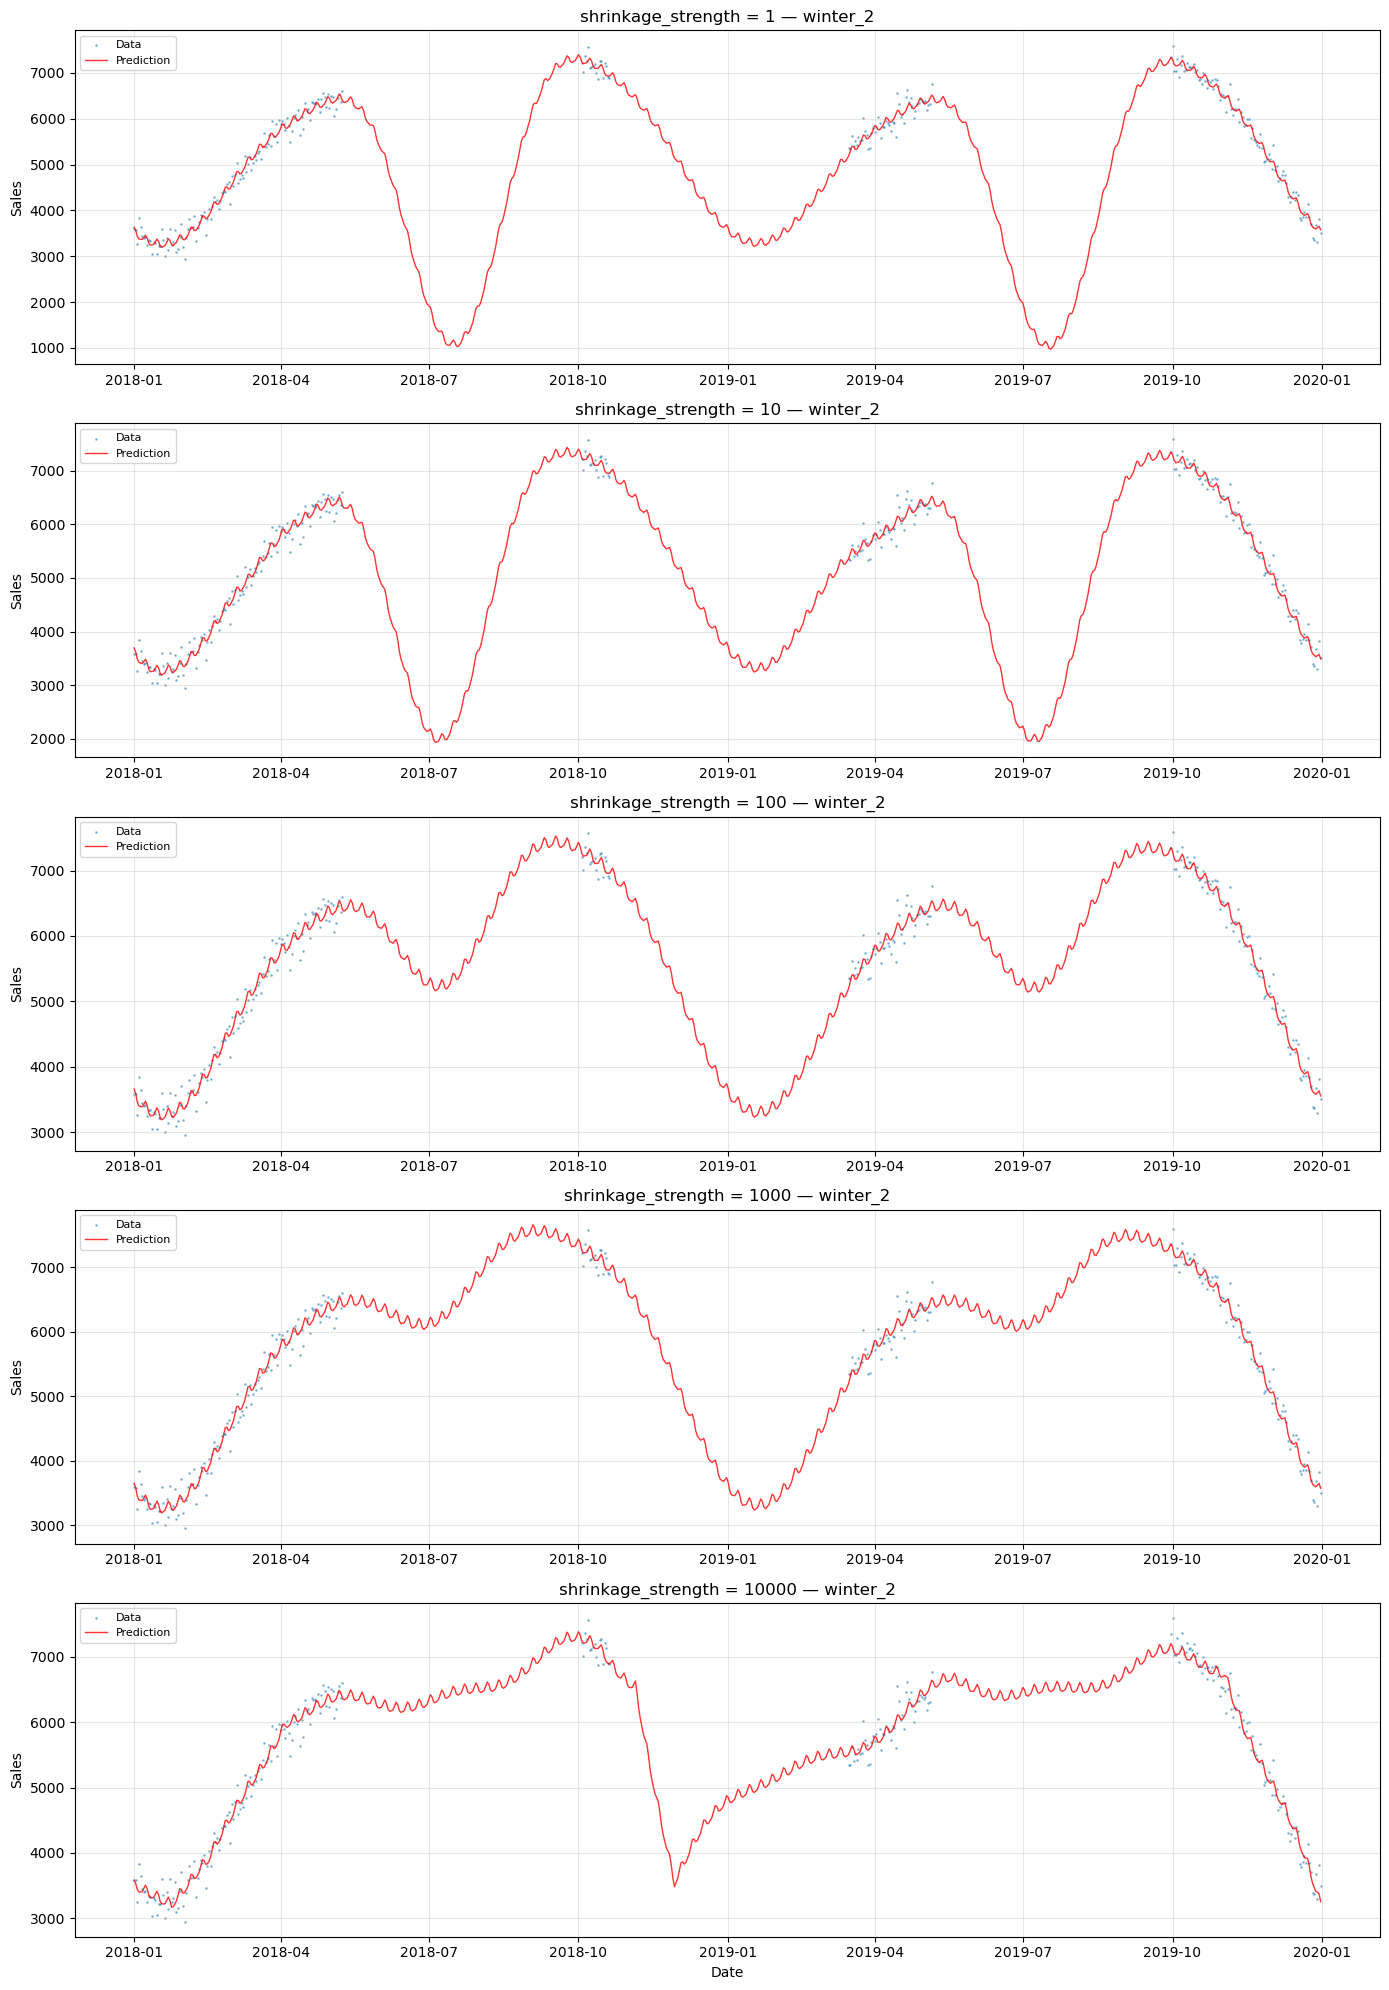

In [5]:
# Compare predictions for winter_2 across shrinkage values
# This series has opposite (winter) seasonality and data gaps
series_name = "winter_2"
series_data = df[df["series"] == series_name]

fig, axes = plt.subplots(len(shrinkage_values), 1, figsize=(14, 4 * len(shrinkage_values)))

for ax, shrinkage in zip(axes, shrinkage_values):
    model = shrinkage_models[shrinkage]
    future = shrinkage_predictions[shrinkage]
    group_code = [k for k, v in model.groups_.items() if v == series_name][0]

    ax.scatter(series_data["ds"], series_data["y"], s=1, alpha=0.4, color="C0", label="Data")
    ax.plot(future["ds"], future[f"yhat_{group_code}"], "r-", linewidth=1, alpha=0.8, label="Prediction")
    ax.set_title(f"shrinkage_strength = {shrinkage} — {series_name}")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

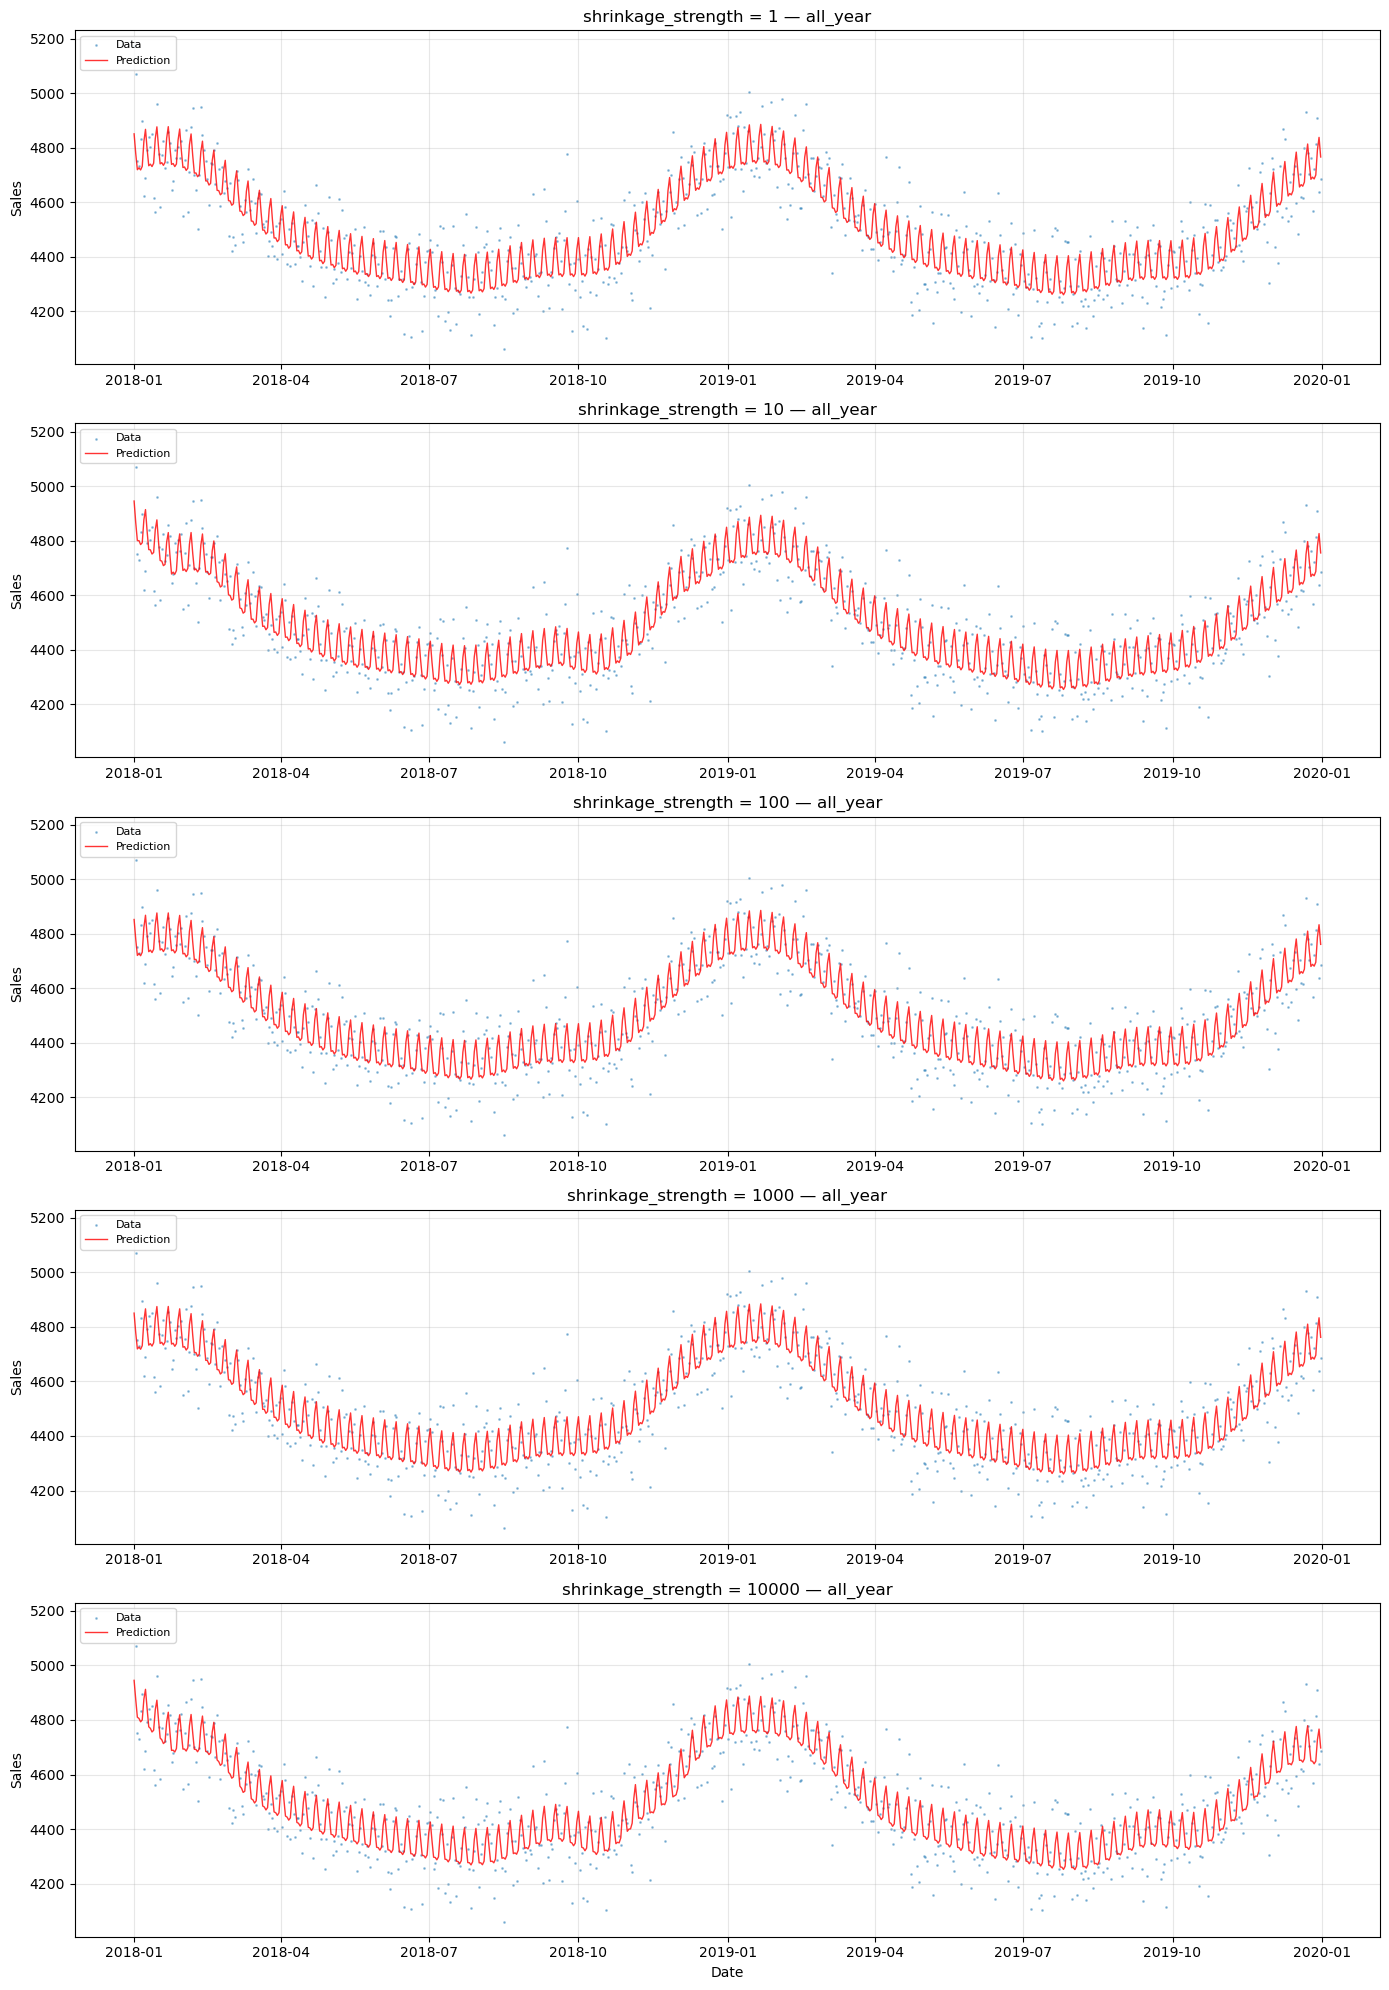

In [6]:
# Compare predictions for all_year across shrinkage values
# This series has complete data and minimal seasonality
series_name = "all_year"
series_data = df[df["series"] == series_name]

fig, axes = plt.subplots(len(shrinkage_values), 1, figsize=(14, 4 * len(shrinkage_values)))

for ax, shrinkage in zip(axes, shrinkage_values):
    model = shrinkage_models[shrinkage]
    future = shrinkage_predictions[shrinkage]
    group_code = [k for k, v in model.groups_.items() if v == series_name][0]

    ax.scatter(series_data["ds"], series_data["y"], s=1, alpha=0.4, color="C0", label="Data")
    ax.plot(future["ds"], future[f"yhat_{group_code}"], "r-", linewidth=1, alpha=0.8, label="Prediction")
    ax.set_title(f"shrinkage_strength = {shrinkage} — {series_name}")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

### Observations

- **Low shrinkage (1)**: Each series has near-complete freedom to learn its own seasonal pattern. This is close to individual fitting — the model may produce erratic predictions in data gaps because there is minimal information sharing.
- **Moderate shrinkage (10–100)**: A balance between sharing and individuality. The shared seasonal pattern provides a reasonable baseline, while individual deviations capture series-specific differences.
- **High shrinkage (1000)**: Series are forced to have very similar seasonal patterns.

The optimal shrinkage depends on:
- How similar the seasonal patterns truly are across series
- How much data each series has (less data → more benefit from sharing)
- Whether the series have opposite seasonality (which complicates the shared mean)

**Bottom line**: `shrinkage_strength` is a hyperparameter that must be tuned. Cross-validation or Bayesian model comparison (e.g., LOO-CV, WAIC) can help select an appropriate value.

---

## Caveat 2: Opposite Seasonality and the UniformConstant

The [timeseers](https://github.com/MBrouns/timeseers) library proposes a clever pattern for handling series with **opposite seasonal patterns** under partial pooling: multiply the seasonality by a `UniformConstant(-1, 1)`:

```python
model = (
    LinearTrend()
    + UniformConstant(-1, 1) * FourierSeasonality(365.25, 5)
    + FourierSeasonality(7, 2)
)
```

The idea is that the constant learns:
- $c \approx +1$ for summer products (keep the seasonal pattern as-is)
- $c \approx -1$ for winter products (flip the seasonal pattern)
- $c \approx 0$ for all-year products (suppress seasonality)

### Why might this be necessary?

Consider what happens with partial pooling on Fourier coefficients when series have **opposite** seasonality:

Without `UniformConstant`:
$$
\beta_{\text{shared}} \sim \text{Normal}(0, \sigma_{\beta})
$$
$$
\beta_i = \beta_{\text{shared}} + z_i \cdot \beta_{\sigma}
$$

Summer products want **positive** $\beta$, winter products want **negative** $\beta$. The shared mean $\beta_{\text{shared}}$ is pulled in both directions and compromises near **zero**. With high shrinkage (small $\beta_{\sigma}$), individual deviations are forced to be small, so all series end up with weak seasonality.

With `UniformConstant`:
$$
c_i \sim \text{Uniform}(-1, 1) \quad \text{(handles direction per series)}
$$
$$
\beta_{\text{shared}} \sim \text{Normal}(0, \sigma_{\beta}) \quad \text{(shared seasonal shape)}
$$
$$
\text{seasonality}_i = c_i \cdot (X \cdot \beta_i)
$$

Now $\beta_{\text{shared}}$ can represent the **magnitude** of the seasonal pattern (consistently positive), while $c_i$ handles the **direction** (sign). High shrinkage on $\beta$ works well because all series genuinely share the same seasonal shape — only the direction differs.

### Or is the model already handling this implicitly?

With **low to moderate shrinkage** on Fourier coefficients, each series' $\beta_i$ can deviate enough from $\beta_{\text{shared}}$ to have opposite signs. The model effectively learns positive coefficients for summer and negative for winter. The sharing benefit is reduced (because $\beta_{\text{shared}} \approx 0$), but it still works.

Let's test both approaches and compare.

### Model without UniformConstant (same as Chapter 05)

This is the same partial pooling model from Chapter 05 with high shrinkage on seasonality.

In [7]:
# Partial pooling without UniformConstant (from Chapter 05)
model_no_uc = (
    LinearTrend(
        n_changepoints=10,
        pool_type="partial",
        delta_pool_type="partial",
        shrinkage_strength=10,
    )
    + FourierSeasonality(
        period=365.25, series_order=5, pool_type="partial", shrinkage_strength=1000
    )
    + FourierSeasonality(
        period=7, series_order=2, pool_type="partial", shrinkage_strength=1000
    )
)

start = time.time()
model_no_uc.fit(df, method="mapx", scale_mode="individual", sigma_pool_type="individual")
time_no_uc = time.time() - start

future_no_uc = model_no_uc.predict(horizon=0, freq="D")
print(f"Without UniformConstant: {time_no_uc:.2f}s")

Output()

Without UniformConstant: 18.06s


### Model with UniformConstant (timeseers pattern)

Now we add `UniformConstant(-1, 1)` as a multiplicative factor on the yearly seasonality. The constant is partially pooled so each series can learn its own direction. All other parameters remain the same.

In [8]:
# Partial pooling with UniformConstant (timeseers pattern)
model_uc = (
    LinearTrend(
        n_changepoints=10,
        pool_type="partial",
        delta_pool_type="partial",
        shrinkage_strength=10,
    )
    + UniformConstant(-1, 1, pool_type="individual")
    ** FourierSeasonality(
        period=365.25, series_order=5, pool_type="partial", shrinkage_strength=1000
    )
    + FourierSeasonality(
        period=7, series_order=2, pool_type="partial", shrinkage_strength=1000
    )
)

start = time.time()
model_uc.fit(df, method="mapx", scale_mode="individual", sigma_pool_type="individual")
time_uc = time.time() - start

future_uc = model_uc.predict(horizon=0, freq="D")
print(f"With UniformConstant: {time_uc:.2f}s")

Output()

With UniformConstant: 46.01s


### Comparing the two approaches

Let's use the built-in `plot()` method to see the component decomposition for a winter product. This shows how each model handles the opposite seasonality.

=== Without UniformConstant ===


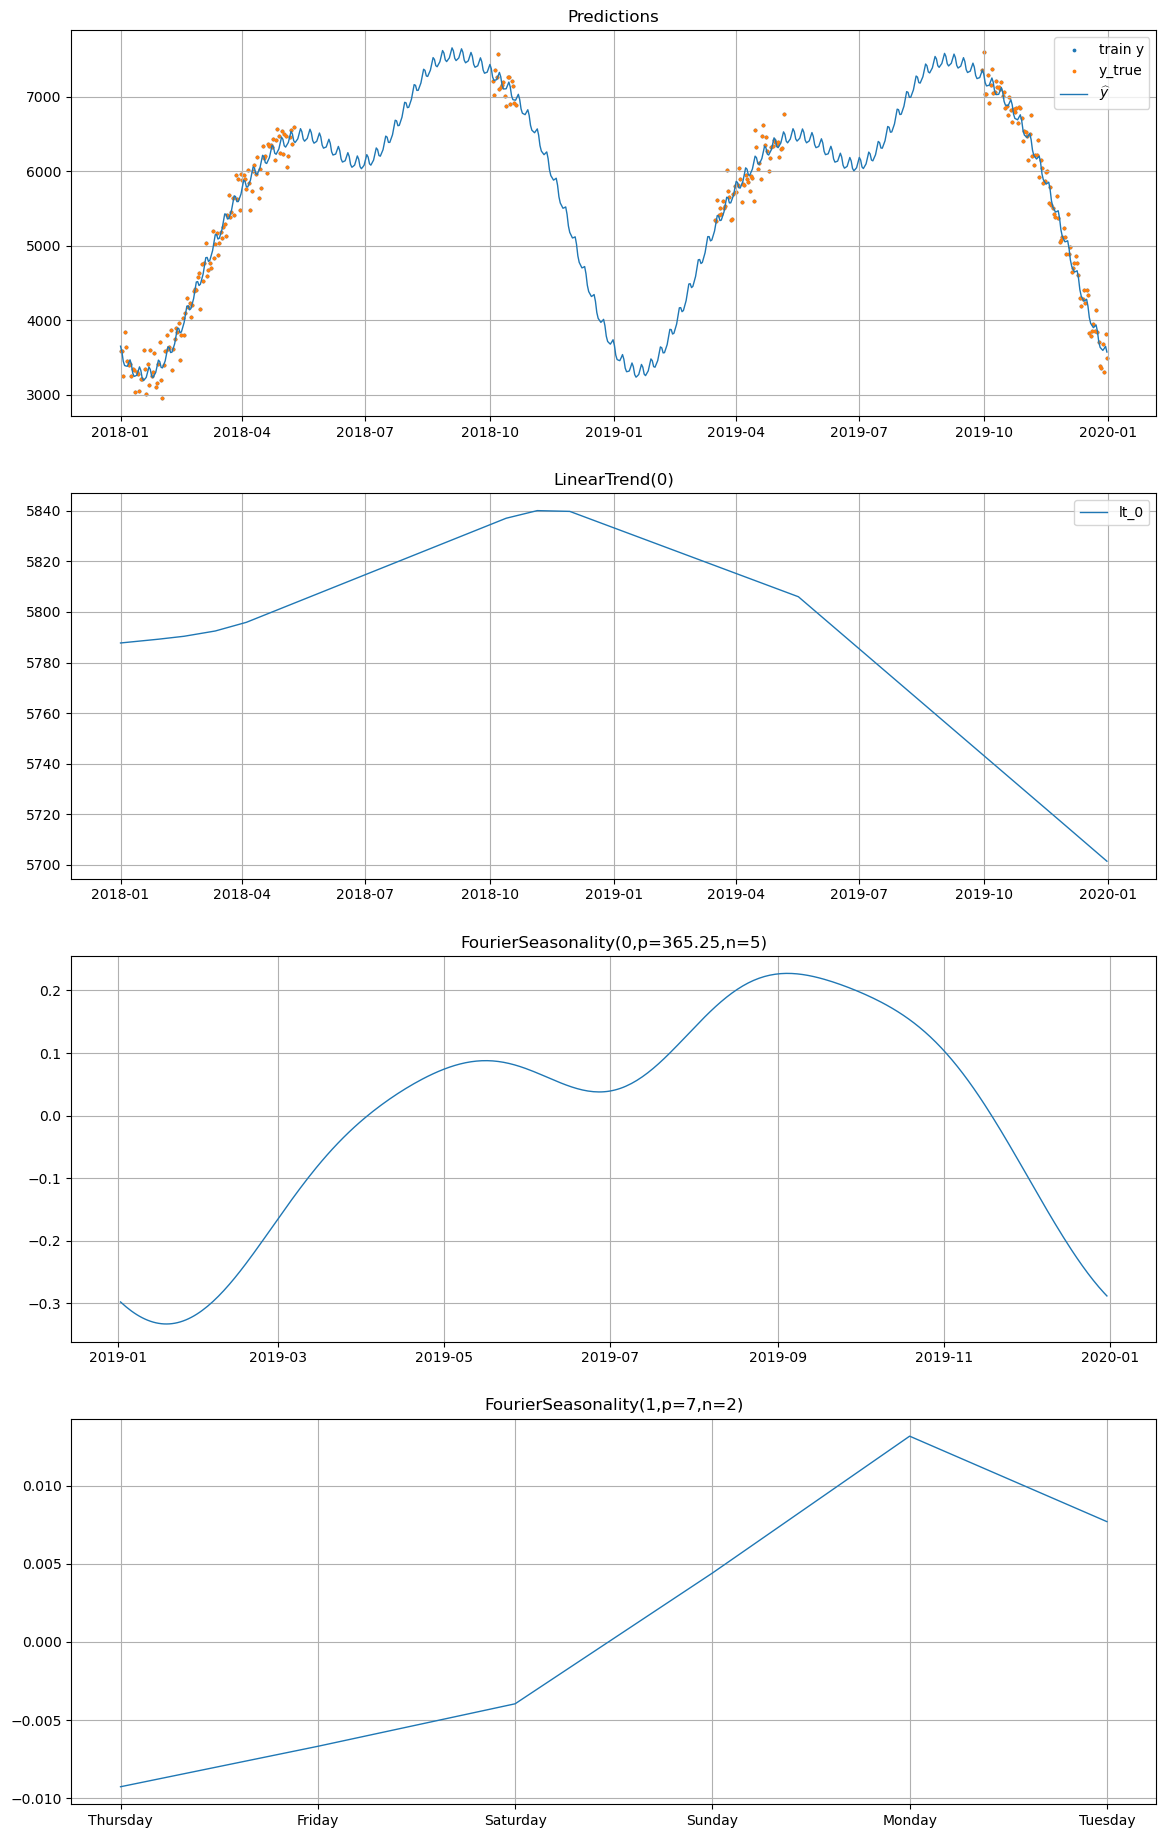

In [9]:
# Plot decomposition for winter_2 WITHOUT UniformConstant
print("=== Without UniformConstant ===")
model_no_uc.plot(future_no_uc, series="winter_2", y_true=df[df["series"] == "winter_2"])

=== With UniformConstant ===


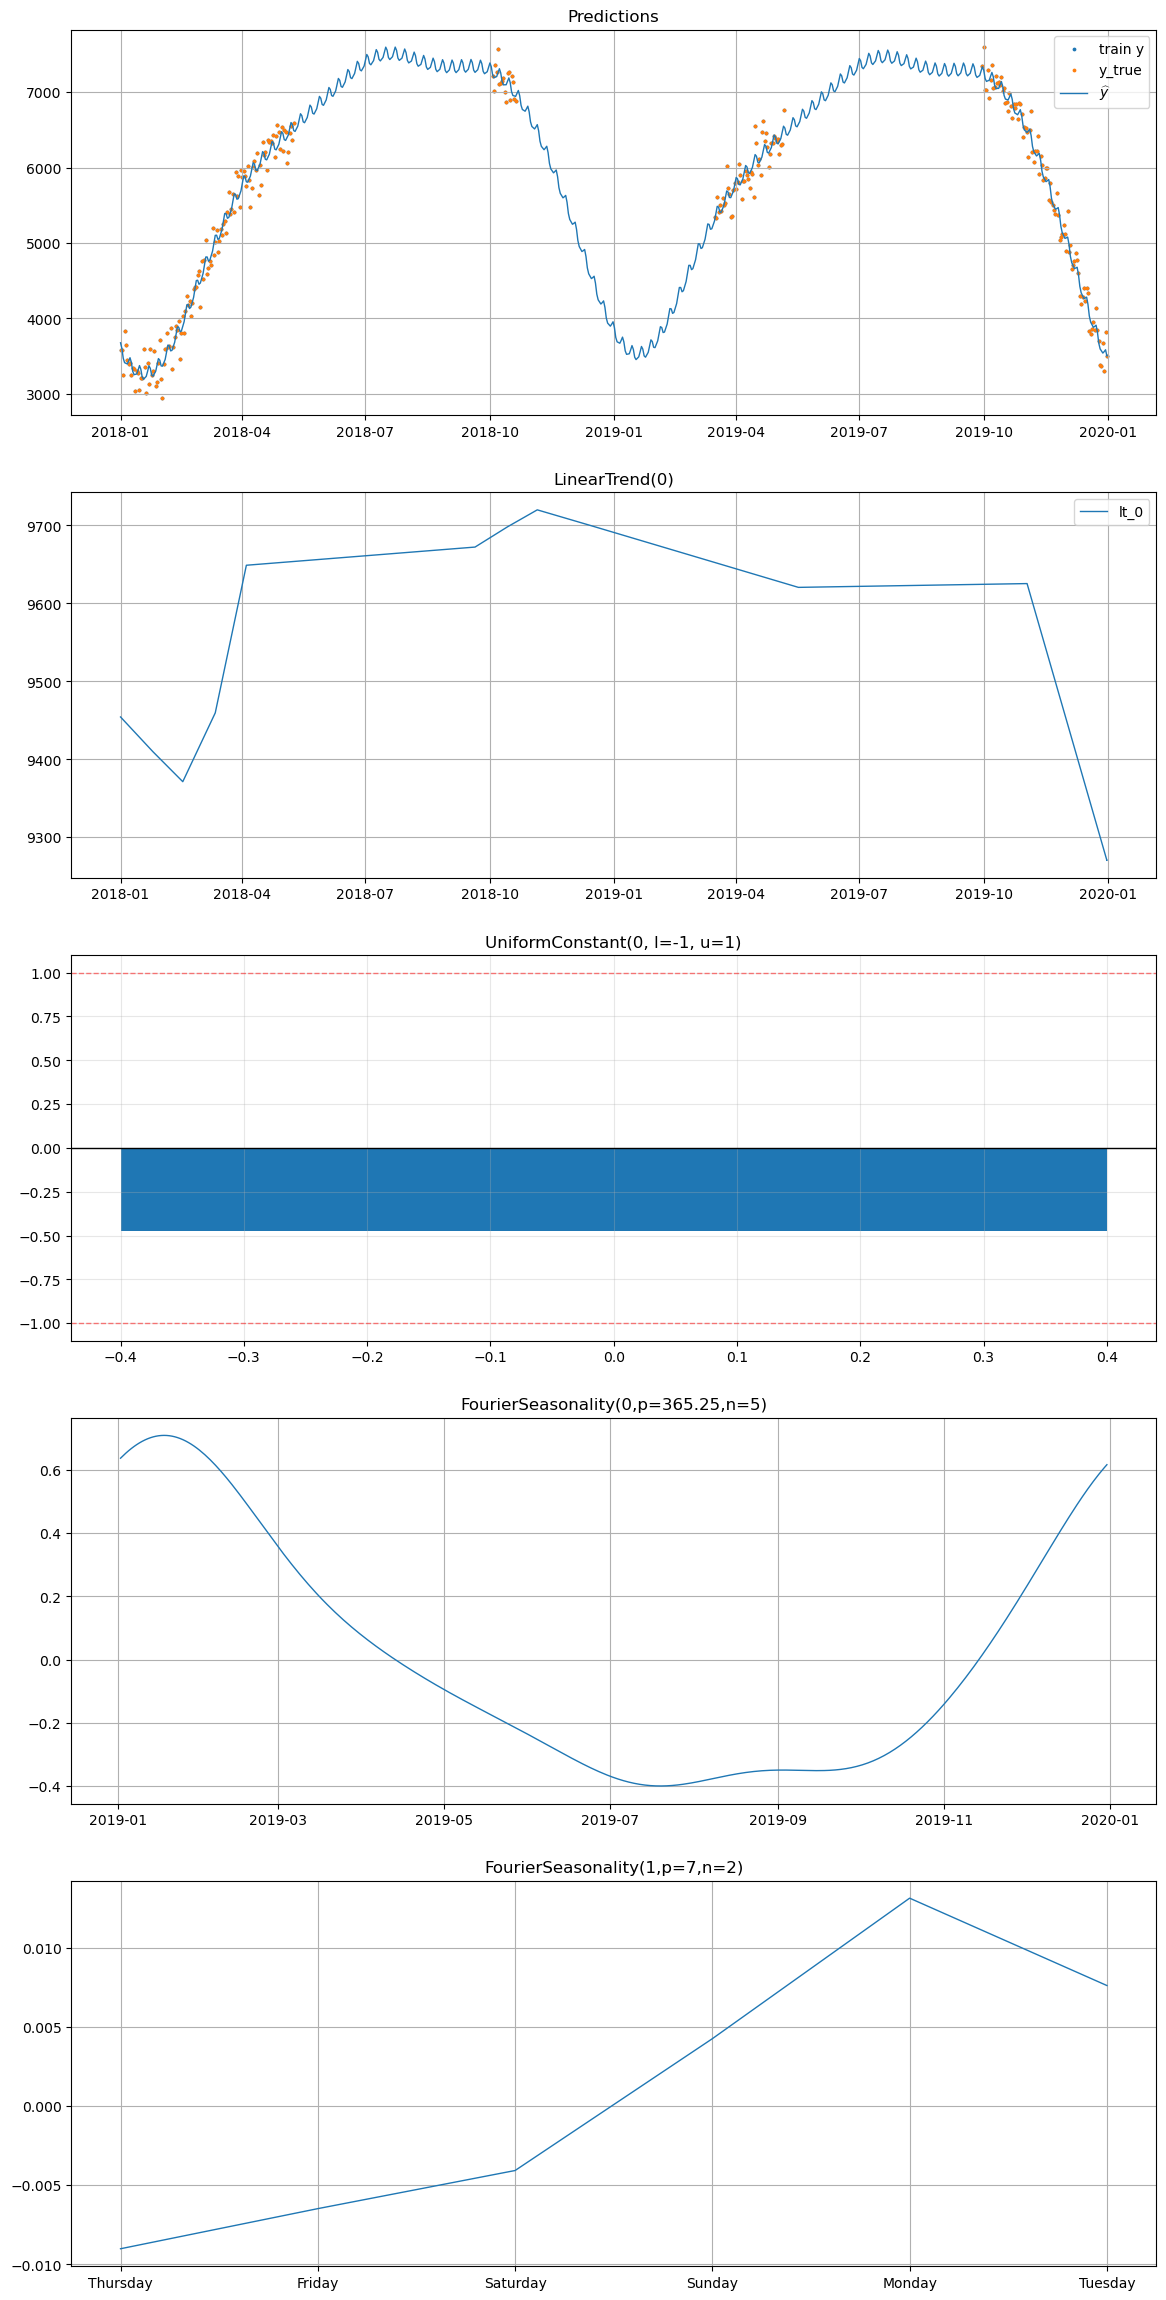

In [10]:
# Plot decomposition for winter_2 WITH UniformConstant
print("=== With UniformConstant ===")
model_uc.plot(future_uc, series="winter_2", y_true=df[df["series"] == "winter_2"])

=== Without UniformConstant ===


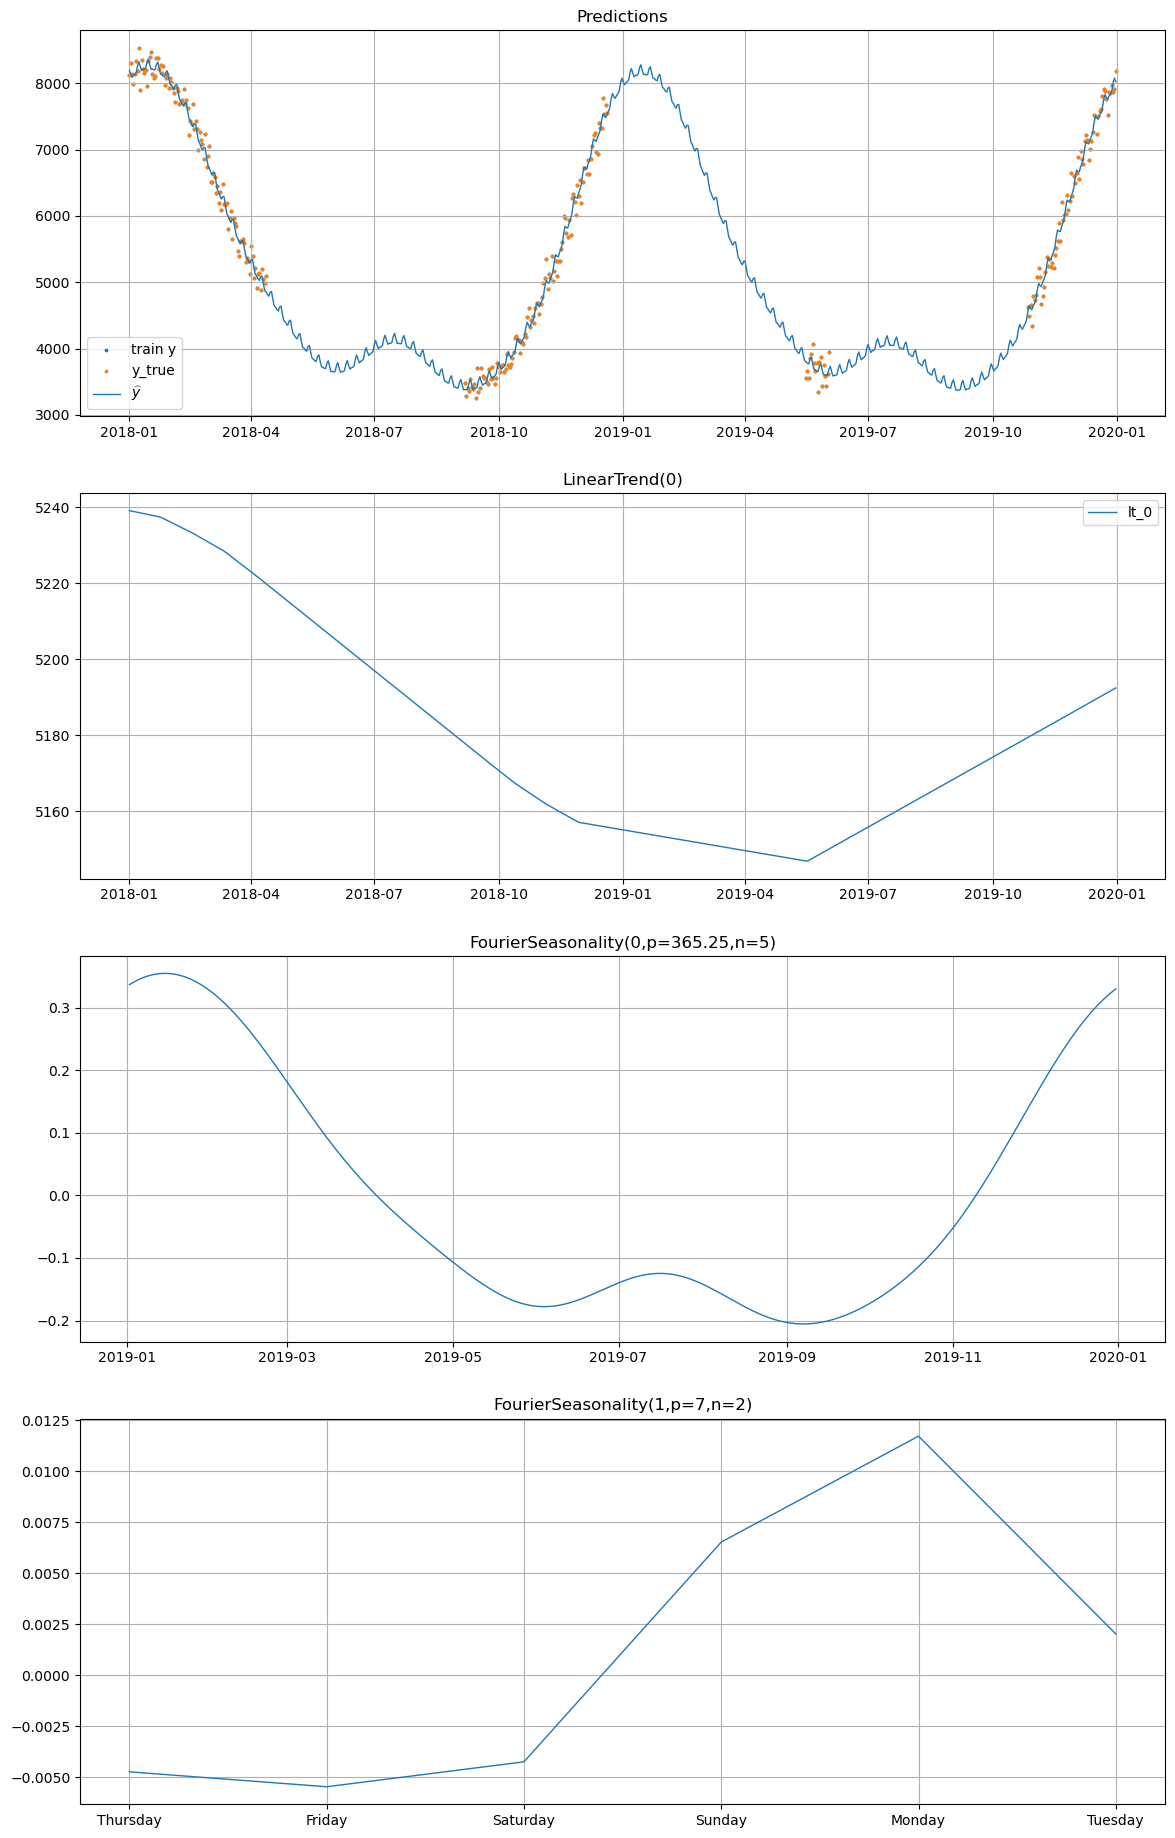

In [11]:
# Plot decomposition for summer_1 WITHOUT UniformConstant
print("=== Without UniformConstant ===")
model_no_uc.plot(future_no_uc, series="summer_1", y_true=df[df["series"] == "summer_1"])

=== With UniformConstant ===


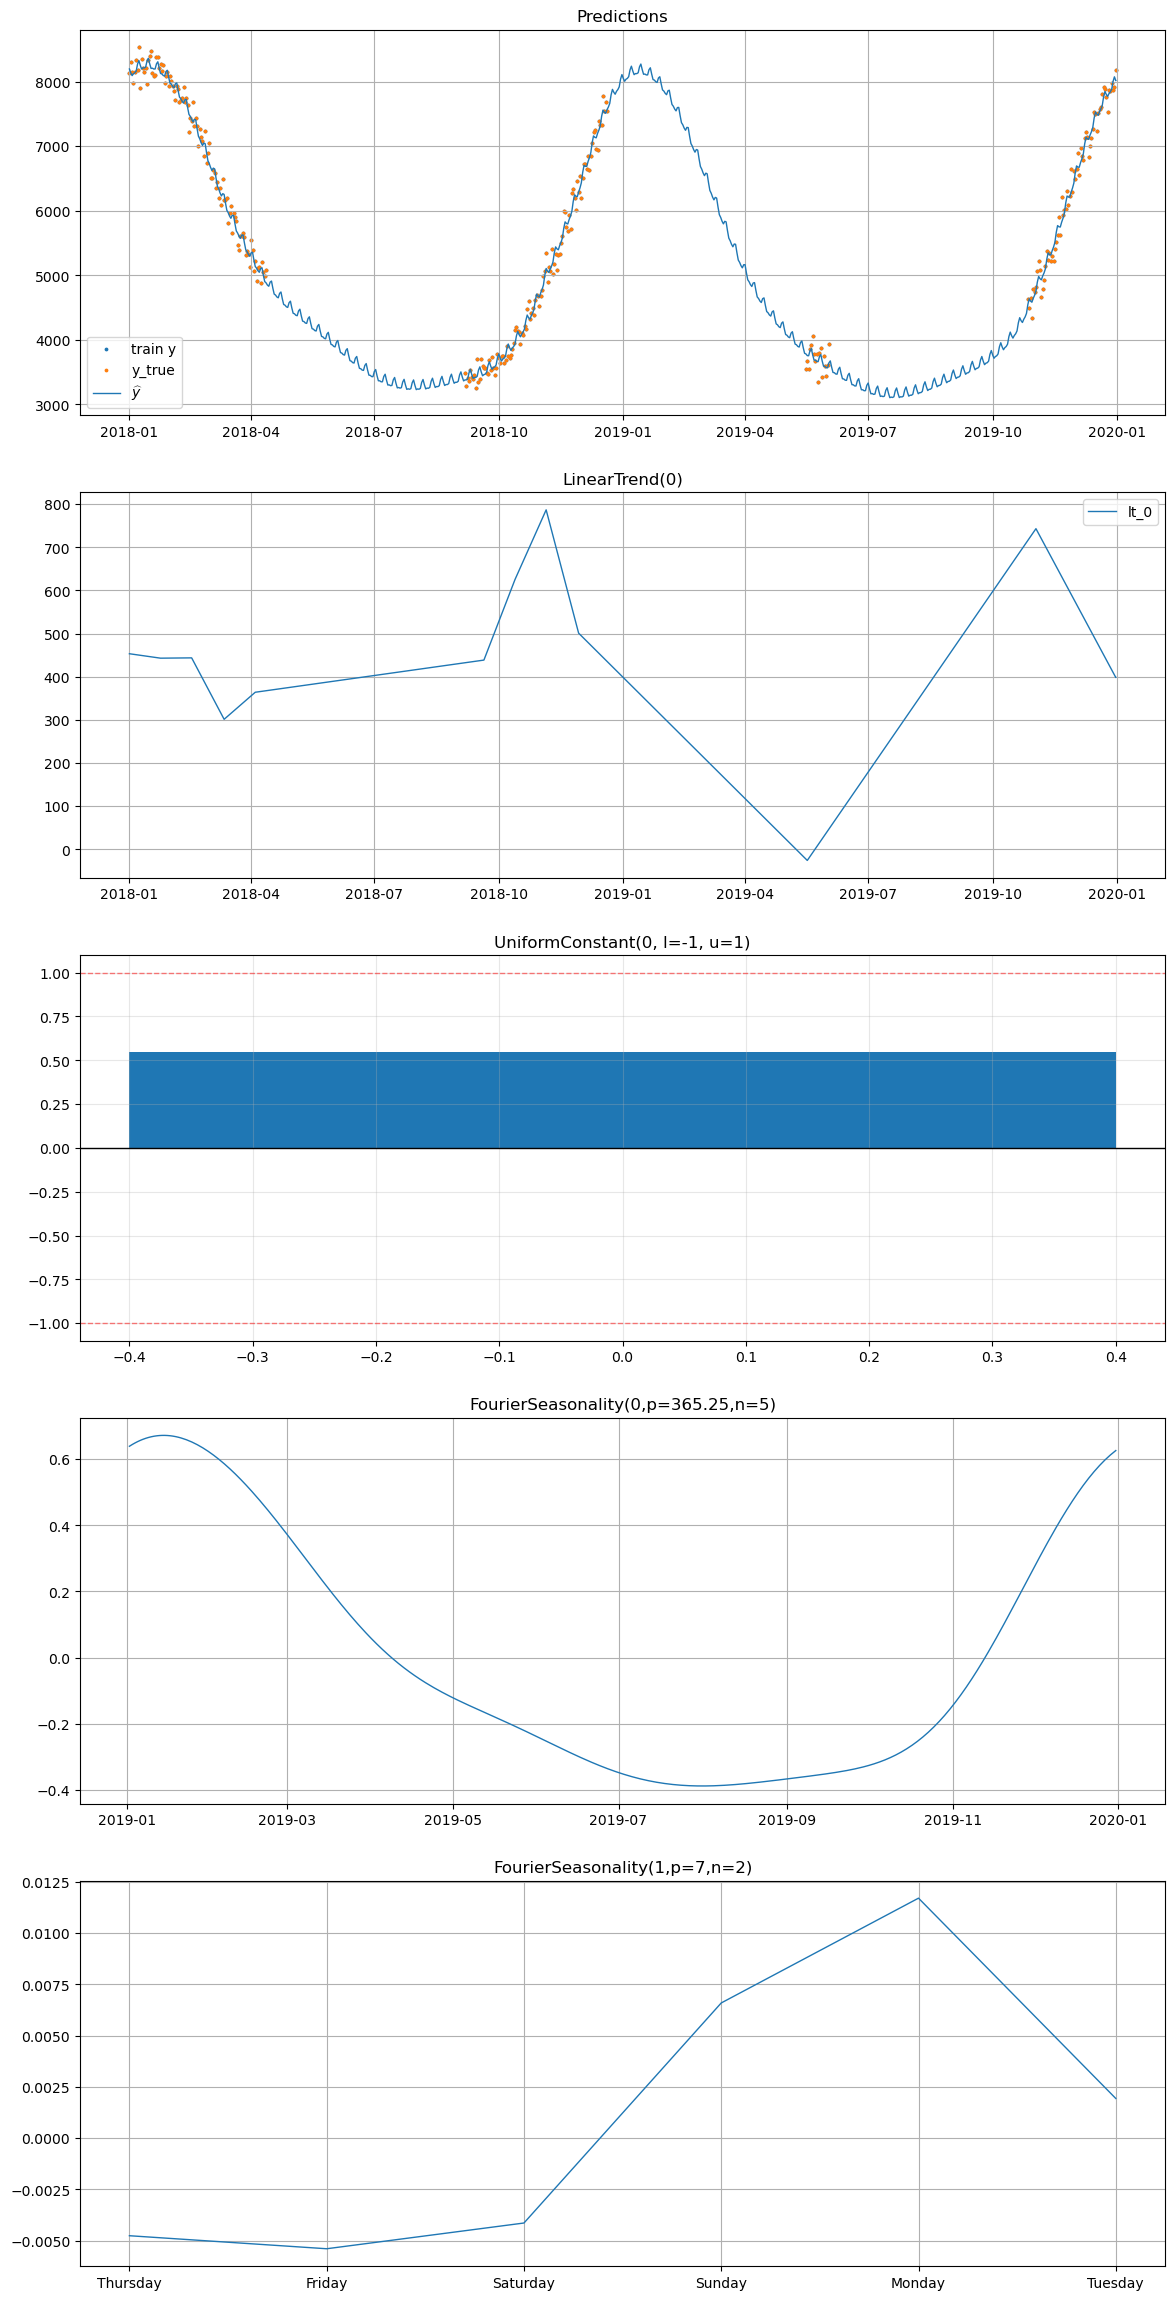

In [12]:
# Plot decomposition for summer_1 WITH UniformConstant
print("=== With UniformConstant ===")
model_uc.plot(future_uc, series="summer_1", y_true=df[df["series"] == "summer_1"])

=== Without UniformConstant ===


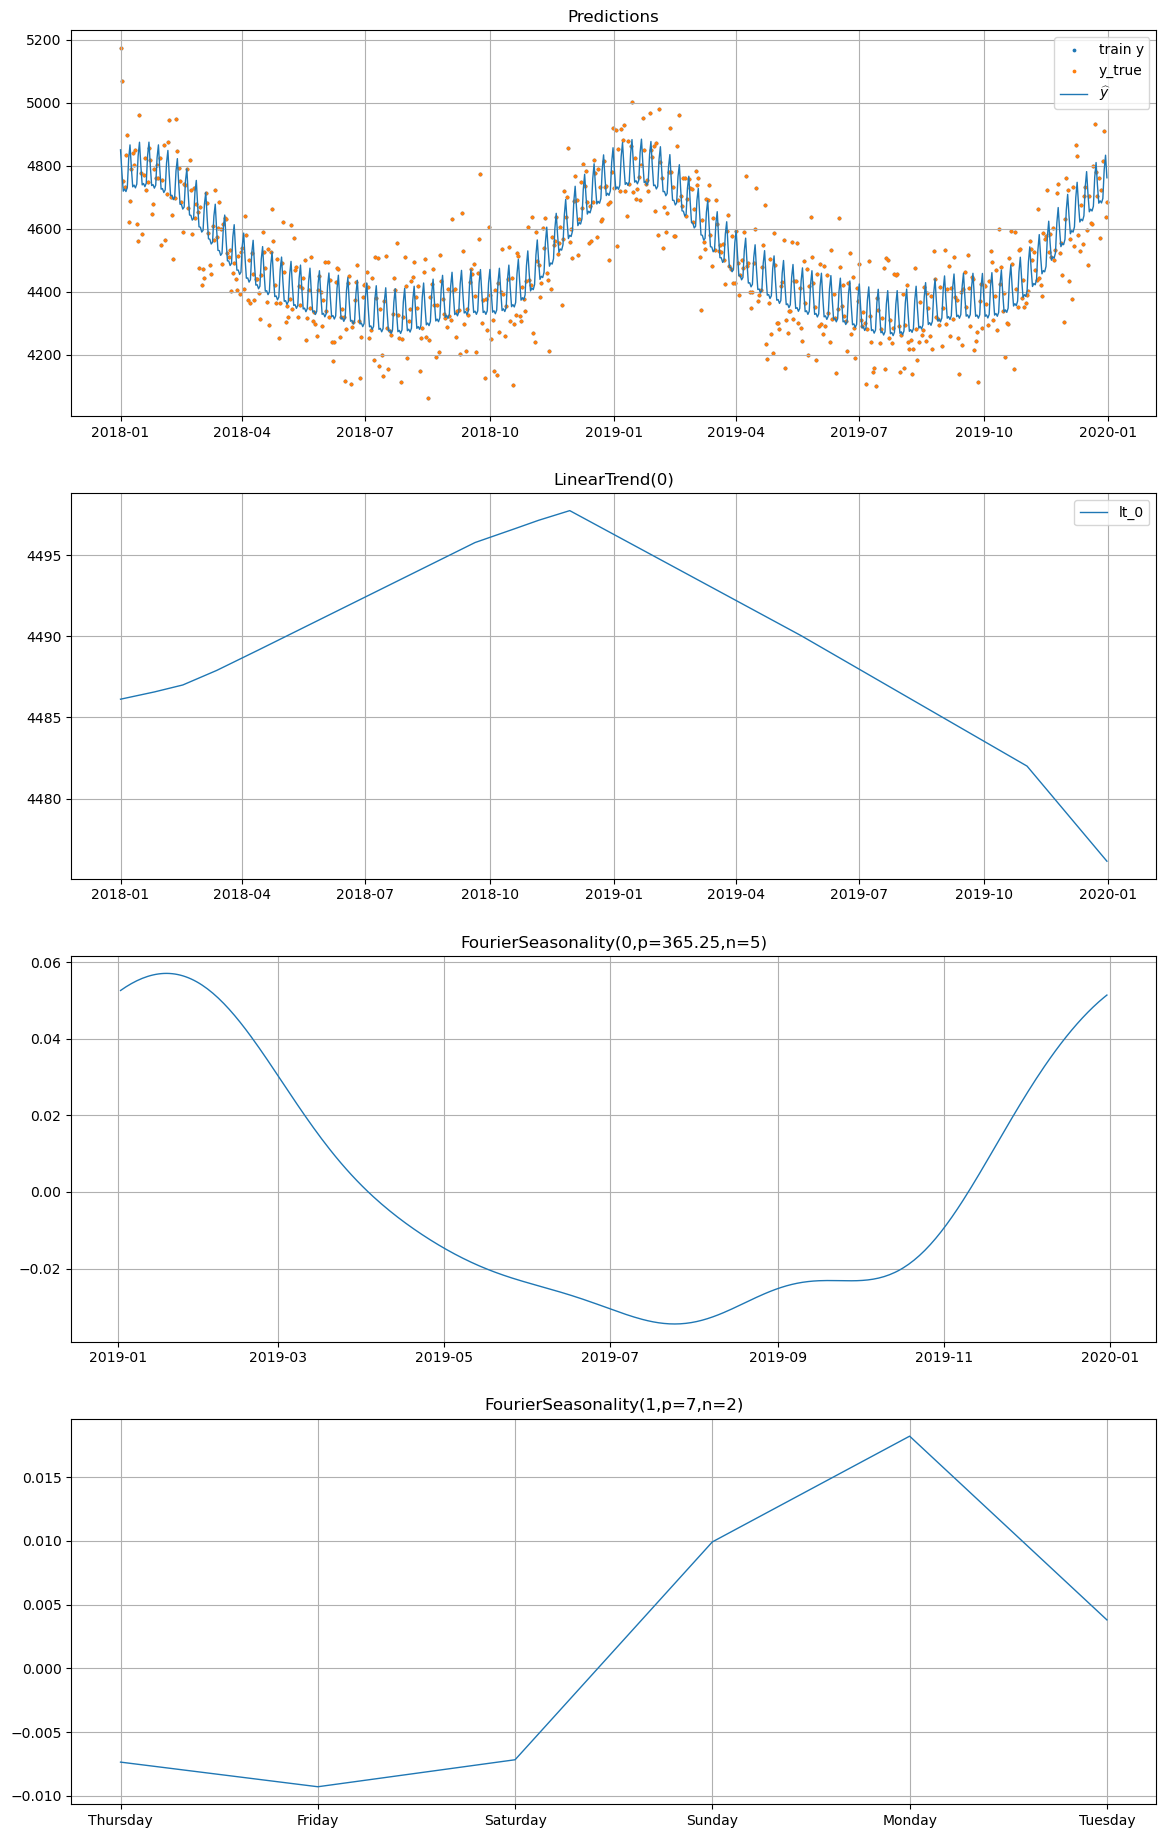

In [13]:
# Plot decomposition for all_year WITHOUT UniformConstant
print("=== Without UniformConstant ===")
model_no_uc.plot(future_no_uc, series="all_year", y_true=df[df["series"] == "all_year"])

=== With UniformConstant ===


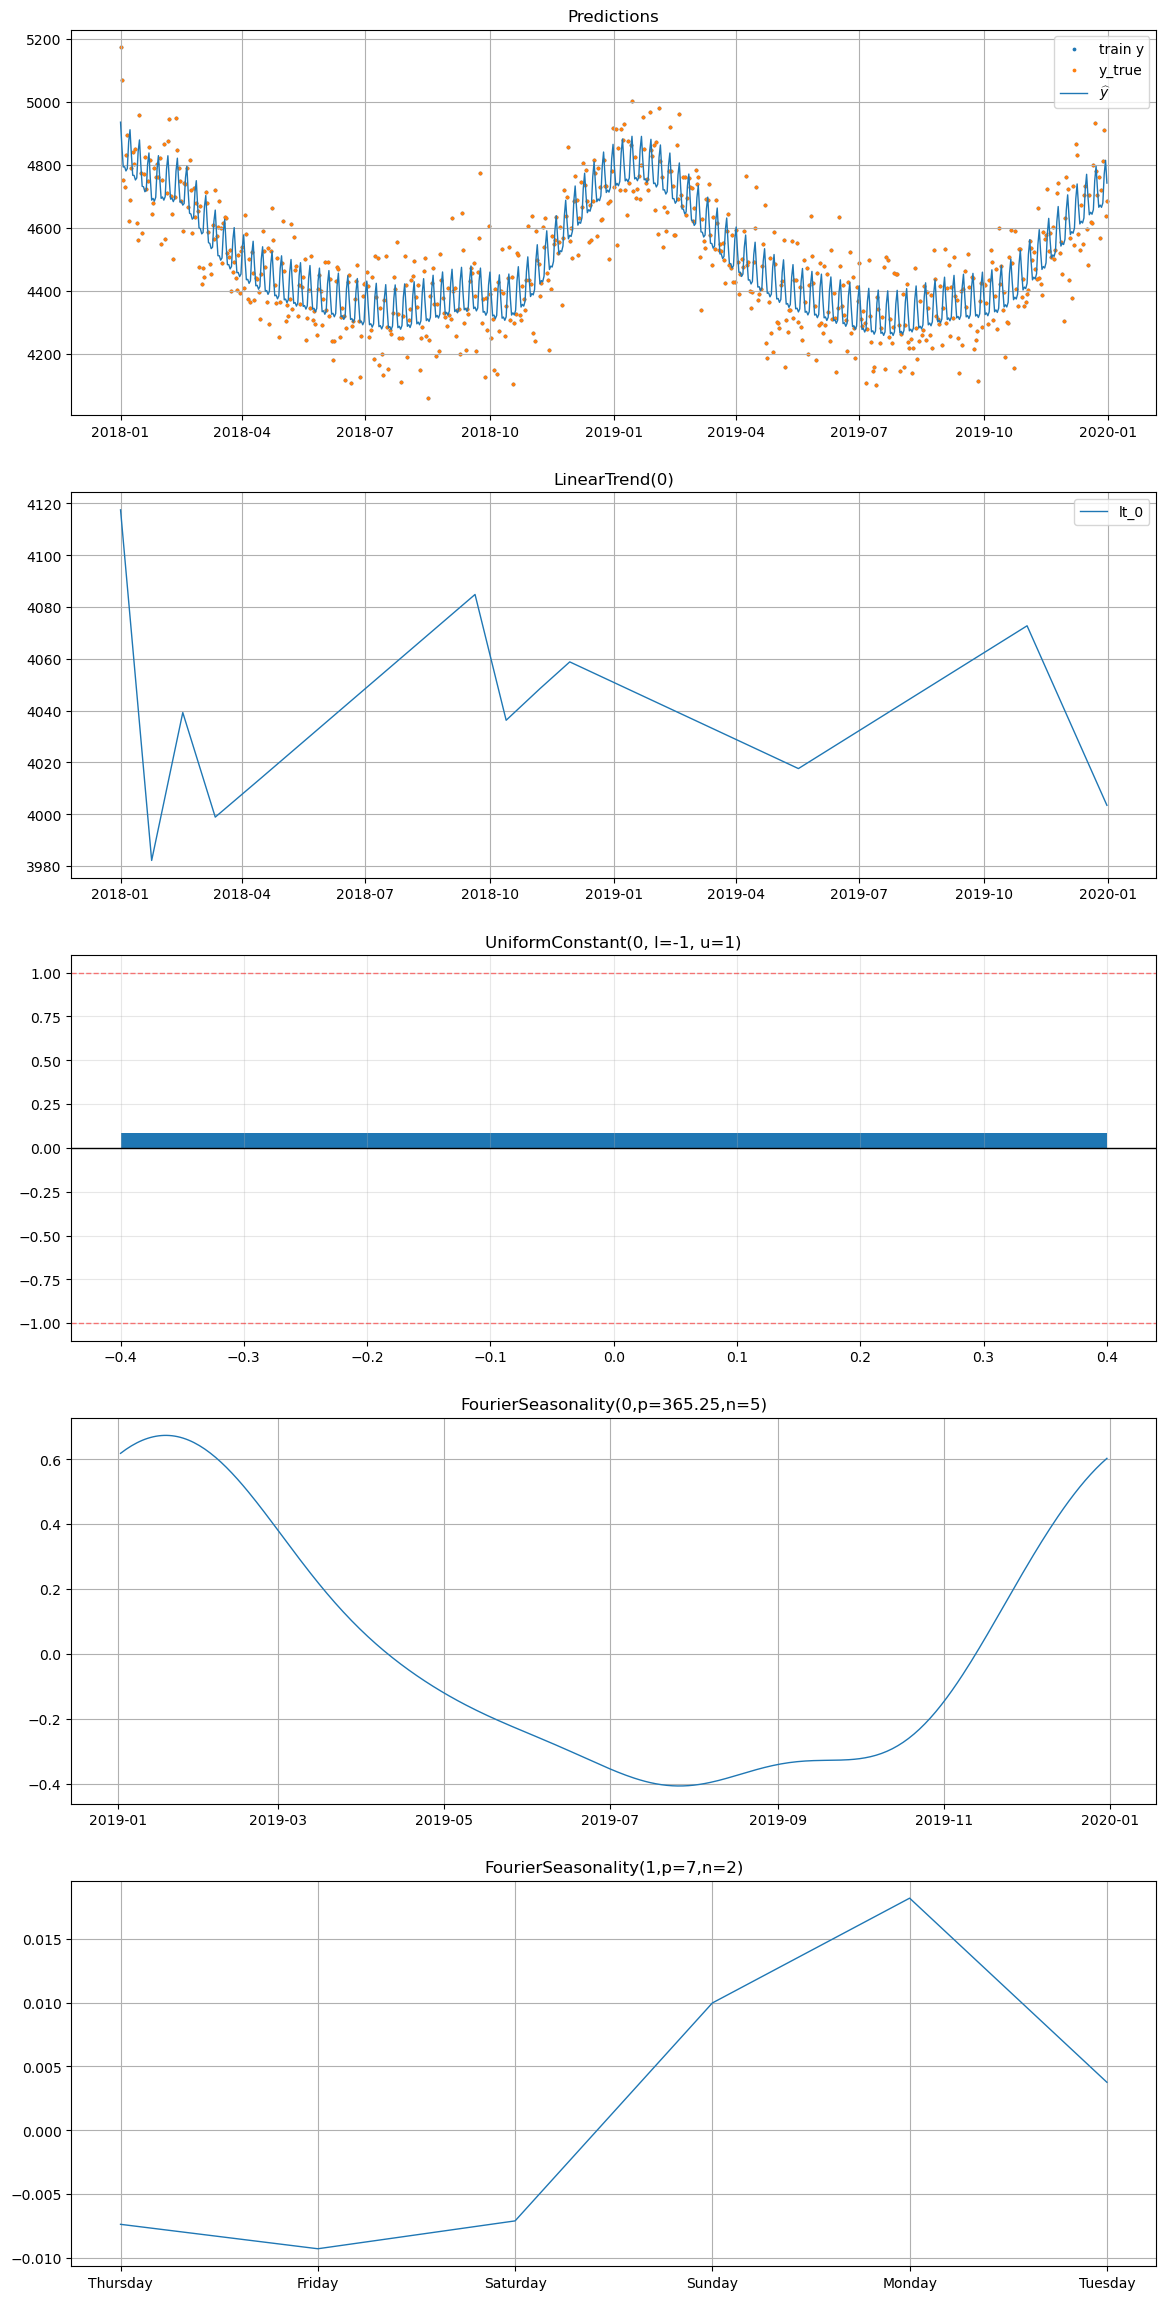

In [14]:
# Plot decomposition for all_year WITH UniformConstant
print("=== With UniformConstant ===")
model_uc.plot(future_uc, series="all_year", y_true=df[df["series"] == "all_year"])

### Side-by-side comparison for all series

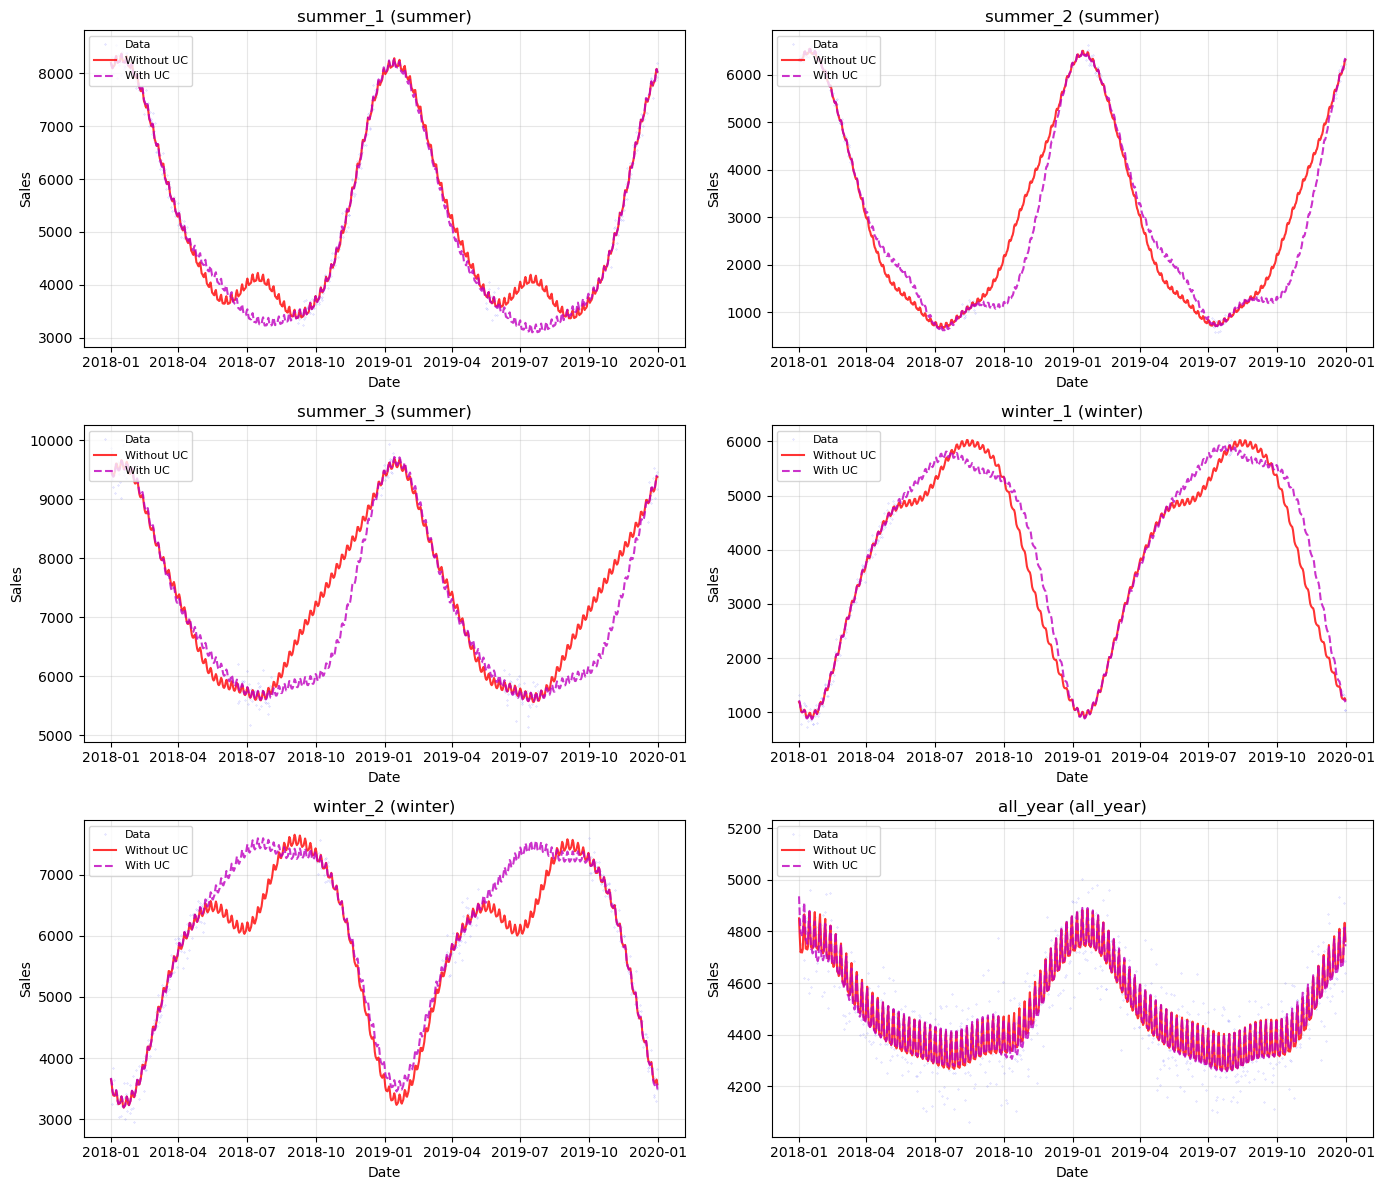

In [15]:
# Overlay predictions from both models for all series
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, params) in enumerate(product_params.items()):
    ax = axes[i]
    series_data = df[df["series"] == name]

    no_uc_group = [k for k, v in model_no_uc.groups_.items() if v == name][0]
    uc_group = [k for k, v in model_uc.groups_.items() if v == name][0]

    ax.plot(series_data["ds"], series_data["y"], "b.", markersize=0.5, alpha=0.3, label="Data")
    ax.plot(future_no_uc["ds"], future_no_uc[f"yhat_{no_uc_group}"], "r-", linewidth=1.5, alpha=0.8, label="Without UC")
    ax.plot(future_uc["ds"], future_uc[f"yhat_{uc_group}"], "m--", linewidth=1.5, alpha=0.8, label="With UC")

    ax.set_title(f"{name} ({params['group']})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# In-sample metrics comparison
comparison_rows = []

for approach_name, model, future in [
    ("Without UC", model_no_uc, future_no_uc),
    ("With UC", model_uc, future_uc),
]:
    for name in product_params.keys():
        group_code = [k for k, v in model.groups_.items() if v == name][0]
        series_data = df[df["series"] == name]
        future_for_metrics = future[["ds", f"yhat_{group_code}"]].copy()
        future_for_metrics.columns = ["ds", "yhat_0"]
        m = metrics(series_data, future_for_metrics, "complete")
        comparison_rows.append({
            "Series": name,
            "Group": product_params[name]["group"],
            "Approach": approach_name,
            "RMSE": m["rmse"].values[0],
            "MAE": m["mae"].values[0],
            "MAPE": m["mape"].values[0],
        })

comparison_df = pd.DataFrame(comparison_rows)
print("Metrics Comparison:")
display(comparison_df)

print("\nSummary by Approach:")
display(
    comparison_df.groupby("Approach")
    .agg({"RMSE": ["mean", "std"], "MAE": ["mean", "std"]})
    .round(2)
)

Metrics Comparison:


,Series,Group,Approach,RMSE,MAE,MAPE
0,summer_1,summer,Without UC,142.152841,114.761139,0.020943
1,summer_2,summer,Without UC,91.518750,74.878657,0.032018
2,summer_3,summer,Without UC,186.977001,146.326295,0.021774
3,winter_1,winter,Without UC,112.821920,93.404084,0.049773
4,winter_2,winter,Without UC,166.712894,131.774282,0.026323
5,all_year,all_year,Without UC,100.746479,79.753239,0.017812
6,summer_1,summer,With UC,140.464419,113.067301,0.020632
7,summer_2,summer,With UC,89.862287,73.439107,0.031606
8,summer_3,summer,With UC,186.548404,145.914661,0.021720
9,winter_1,winter,With UC,110.110254,90.501832,0.048353



Summary by Approach:


RMSE            MAE       
              mean    std    mean    std
Approach                                
With UC     131.96  38.54  105.30  28.93
Without UC  133.49  38.21  106.82  28.91

### Analysis

**Without UniformConstant**: The partial pooling model with high shrinkage on the Fourier coefficients ($\text{shrinkage\_strength} = 1000$) forces the shared seasonal mean $\beta_{\text{shared}}$ close to zero, because summer and winter products pull in opposite directions. The individual deviations $\beta_{\sigma}$ must compensate, but their prior is very tight. As a result, the model may produce weaker seasonal patterns, or the optimizer may find a solution where the seasonal signal is partly absorbed into the trend or noise.

**With UniformConstant**: The constant $c_i$ absorbs the sign difference between groups. Summer products learn $c \approx +1$, winter products learn $c \approx -1$, and the all-year product learns $c \approx 0$. This means $\beta_{\text{shared}}$ can represent the actual seasonal **shape** (magnitude and phase), and high shrinkage genuinely forces series to share the same seasonal shape — the intended behavior.

### Conclusion

The results reveal important insights about how partial pooling handles opposite seasonality. The `UniformConstant` trick is **not strictly necessary** — partial pooling can handle opposite seasonality by allowing individual deviations to have opposite signs. However, it becomes **increasingly valuable** as shrinkage strength increases:

| Shrinkage | Without UC | With UC |
|-----------|-----------|--------|
| Low (1-10) | Works fine — individual betas can freely deviate | Adds complexity with little benefit |
| Moderate (10-100) | May weaken some seasonal patterns | Better separation of shape vs direction |
| High (100-1000) | Shared mean ≈ 0, weak seasonality | Shared shape is meaningful, direction via constant |

The `UniformConstant` approach is most useful when:
1. You have series with genuinely **opposite** seasonality (not just different amplitudes)
2. You want **strong shrinkage** to share seasonal shape across series
3. The seasonal **shape** is similar across groups but the **direction** differs

If your series have simply **different** (not opposite) seasonal patterns, the `UniformConstant` adds unnecessary complexity and you are better off with lower shrinkage on the Fourier coefficients directly.

---

## Summary

Hierarchical modeling with partial pooling is a powerful technique, but it comes with important caveats:

1. **Shrinkage strength is a hyperparameter**. There is no universal default. Too little shrinkage gives up the sharing benefit; too much forces series to be more similar than they truly are. Tune it via cross-validation or domain knowledge.

2. **Opposite seasonality requires care**. When series have opposite seasonal patterns, the shared Fourier coefficients are pulled toward zero under high shrinkage. The `UniformConstant(-1, 1)` trick from timeseers elegantly separates *seasonal shape* from *seasonal direction*, enabling strong shrinkage on the shape while allowing the direction to vary per series. Without it, the model can still work with lower shrinkage, but the sharing benefit is reduced.

These caveats are not weaknesses — they are inherent to any hierarchical model. Understanding them helps practitioners make informed modeling choices rather than blindly applying defaults.